# 3. Manejando Netcdf

Para manejar netcdfs usando python haremos uso extensivo de los paquetes estrella de la plataforma Pangeo. Pangeo es un esfuerzo de la comunidad que promueve la reproductibilidad, escalamiento y transparencia en la ciencia.

El paquete de cabecera para el manejo de netcdfs será [xarray](http://xarray.pydata.org/en/latest/). Xarray extiende las capacidades de numpy en el manejo de datos n-dimensionales introduciendo etiquetas en forma de dimensiones, coordenadas y atributos que facilitan las operaciones sobre los mismos. El motor para las operaciones entre fechas es proporcionado por pandas y la escalabilidad de los datos es proporcionado por dask, lo cual convierte a este paquete en una herramienta poderosa.

In [2]:
import numpy as np
import xarray as xr

## 3.1 Estructuras de xarray

xarray cuenta con dos estructuras simples que son fundamentales comprender para un mejor uso del paquete. Esta es una brevisima descripción sobre algunos conceptos claves que se deben tener presentes, mayor informacion la pueden encontrar siempre en la [documentacion](http://xarray.pydata.org/en/stable/data-structures.html#)

### 3.1.1 DataArray

Un `DataArray` es virtualmente igual a un arreglo n-dimensional de numpy que cuenta con etiquetas en sus dimensiones, siendo el elemento base de xarray. Para denifinir un `DataArray` necesitaremos proporcionar, como mínimo, una arreglo de elementos numéricos.

In [4]:
xr.DataArray(np.random.randn(10,40))

<xarray.DataArray (dim_0: 10, dim_1: 40)>
array([[-0.413072, -0.111405,  0.564924, ...,  1.056873, -1.152082,  0.017799],
       [-0.650248, -0.984364, -0.892066, ..., -0.128659, -0.036238, -0.419577],
       [ 0.570987,  1.100929,  0.579666, ...,  0.860146, -0.432139, -1.223264],
       ...,
       [ 1.096071, -0.28594 ,  1.296236, ...,  0.20883 , -0.847503,  1.279911],
       [-0.055404,  0.940172, -0.014826, ...,  0.586583,  0.339597,  0.525842],
       [ 0.07328 , -0.865689, -0.532319, ...,  0.789331, -0.708988,  1.702391]])
Dimensions without coordinates: dim_0, dim_1

Como podemos observar, xarray automaticamente asignó nombres a las dimensiones y nos informa que no encuentra coordenadas asociadas a estas dimensiones. Ahora procederemos a declarar un `DataArray` con la información que falta

In [19]:
# Creamos un poco de data falsa
lat = np.arange(-90, 90, 0.25)
lon = np.arange(0, 360, 0.25)
llon, llat = np.meshgrid(lon, lat)
data = np.cos(llat)+np.cos(llon)/10+np.random.randn(*llon.shape)

# Creamos el DataArray
xarr = xr.DataArray(data, coords=[lat,lon], dims=["lat","lon"])
xarr

<xarray.DataArray (lat: 720, lon: 1440)>
array([[-0.671081,  0.28321 , -0.271469, ...,  0.803275, -1.400716, -0.870977],
       [-1.346807, -0.467721,  0.658405, ...,  0.960853,  0.807965, -0.388102],
       [ 0.661922,  1.095282,  0.527944, ..., -0.701185,  0.966096, -0.871687],
       ...,
       [ 0.610335,  0.74741 ,  0.673897, ..., -0.012894,  1.133553,  1.302177],
       [ 0.88377 ,  0.306493,  0.365532, ...,  0.25173 , -2.26928 ,  1.563047],
       [-1.26468 ,  1.035366,  0.172543, ..., -0.089775, -0.508999, -0.484223]])
Coordinates:
  * lat      (lat) float64 -90.0 -89.75 -89.5 -89.25 ... 89.0 89.25 89.5 89.75
  * lon      (lon) float64 0.0 0.25 0.5 0.75 1.0 ... 359.0 359.2 359.5 359.8

Nuestro `DataArray` ha sido creado dentro de la variable `xarr` satisfactoriamente con las dimensiones y coordenadas asignadas correctamente. Ahora podemos acceder a los métodos que xarray ofrece para sus objetos.

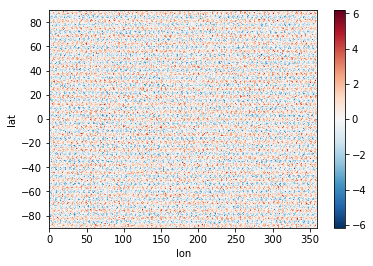

In [18]:
xarr.plot()

### 3.1.2 Dataset

Un `Dataset` es la representación en la memoria del sistema de un archivo netcdf. Un `Dataset` es un conjunto de `DataArray`

## 3.2 Datos Reales

Para cargar datos en formato netcdf a una variable, se hacer uso de la función `open_dataset` (en el caso de tener 1 solo archivo) o `open_mfdataset` en caso de tener muchos archivos

In [20]:
ersstv5 = xr.open_dataset('../Data/sst.mnmean.nc')
ersstv5

<xarray.Dataset>
Dimensions:    (lat: 89, lon: 180, nbnds: 2, time: 1988)
Coordinates:
  * lat        (lat) float32 88.0 86.0 84.0 82.0 ... -82.0 -84.0 -86.0 -88.0
  * lon        (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 352.0 354.0 356.0 358.0
  * time       (time) datetime64[ns] 1854-01-01 1854-02-01 ... 2019-08-01
Dimensions without coordinates: nbnds
Data variables:
    time_bnds  (time, nbnds) float64 ...
    sst        (time, lat, lon) float32 ...
Attributes:
    climatology:               Climatology is based on 1971-2000 SST, Xue, Y....
    description:               In situ data: ICOADS2.5 before 2007 and NCEP i...
    keywords_vocabulary:       NASA Global Change Master Directory (GCMD) Sci...
    keywords:                  Earth Science > Oceans > Ocean Temperature > S...
    instrument:                Conventional thermometers
    source_comment:            SSTs were observed by conventional thermometer...
    geospatial_lon_min:        -1.0
    geospatial_lon_max:        359.0

In [27]:
ersstv5.sst

<xarray.DataArray 'sst' (time: 1988, lat: 89, lon: 180)>
array([[[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       ...,

       [[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]],

       [[-1.8, -1.8, ..., -1.8, -1.8],
        [-1.8, -1.8, ..., -1.8, -1.8],
        ...,
        [ nan,  nan, ...,  nan,  nan],
        [ nan,  nan, ...,  nan,  nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 88.0 86.0 84.0 82.0 80.0 ... -82.0 -84.0 -86.0 -88.0
  * lon      (lon) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * time     (time) datetime64[ns] 1854-01-01 1854-02-01 

In [36]:
iri_errst = xr.open_dataset("http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/dods",decode_times=False)
iri_errst

<xarray.Dataset>
Dimensions:  (T: 1988, X: 180, Y: 89, zlev: 1)
Coordinates:
  * zlev     (zlev) float32 0.0
  * X        (X) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * T        (T) float32 -1271.5 -1270.5 -1269.5 -1268.5 ... 713.5 714.5 715.5
  * Y        (Y) float32 -88.0 -86.0 -84.0 -82.0 -80.0 ... 82.0 84.0 86.0 88.0
Data variables:
    sst      (T, zlev, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

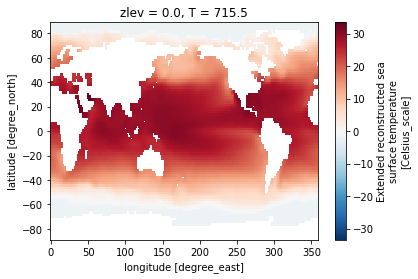

In [37]:
iri_errst.sst.isel(zlev=0,T=-1).plot()